# Predicting the Sale Price of a Building in NYC (2016-2017)
### Data Cleaning
### Choosing Predictors
### Fitting/ Testing Models
- Decision Tree
- Random Forest
- Ridge Regression
- Lasso Regression
- Linear Model

### Conclusions
Kevin, Diego, Jack, Vamsi

In [293]:
## IMPORT LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model as lm
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

In [280]:
# Path of the file to read
NYC_File_Path = 'nyc-rolling-sales.csv'

# Data Cleaning
home_data = pd.read_csv(NYC_File_Path)
home_data = home_data.dropna(axis=0) # eliminating any NaN values
home_data = home_data[home_data['LAND SQUARE FEET'] != ' -  '] # eliminating dashes in these
home_data = home_data[home_data['SALE PRICE'] != ' -  ']
home_data = home_data[home_data['GROSS SQUARE FEET'] != ' -  ']
home_data = home_data[home_data['YEAR BUILT'] > 10] # takes out some years that are 0

# Adding integer type columns & Changing numerical types to str for categorical variables
sale_price = pd.to_numeric(home_data['SALE PRICE'], errors='coerce')
land_square_feet = pd.to_numeric(home_data['LAND SQUARE FEET'], errors='coerce')
gross_square_feet = pd.to_numeric(home_data['GROSS SQUARE FEET'], errors='coerce')
home_data['land_square_feet_int'] = land_square_feet
home_data['gross_square_feet_int'] = gross_square_feet
home_data['sale_price_int'] = sale_price

# Removing values of transactions less than $ 1000 (not reflective of true value)
low_lim = 1000
home_data = home_data[home_data['sale_price_int'] > low_lim] # removing nonsense values
print(home_data.shape)
home_data.head()

(35288, 25)


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,land_square_feet_int,gross_square_feet_int,sale_price_int
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00,1633,6440,6625000
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00,2272,6794,3936272
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00,2369,4615,8000000
6,10,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,,C4,210 AVENUE B,...,1750,4226,1920,2,C4,3192840,2016-09-23 00:00:00,1750,4226,3192840
9,13,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,,D9,629 EAST 5TH STREET,...,4489,18523,1920,2,D9,16232000,2016-11-07 00:00:00,4489,18523,16232000


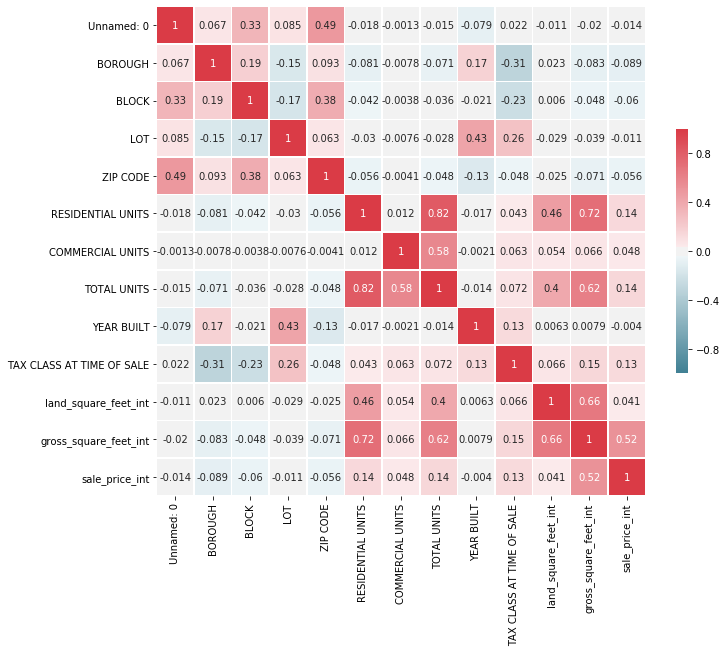

In [281]:
## CORRELATION MATRIX
corr = home_data.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

Use Pairplot for quantitative variables, box plots for qualitative.

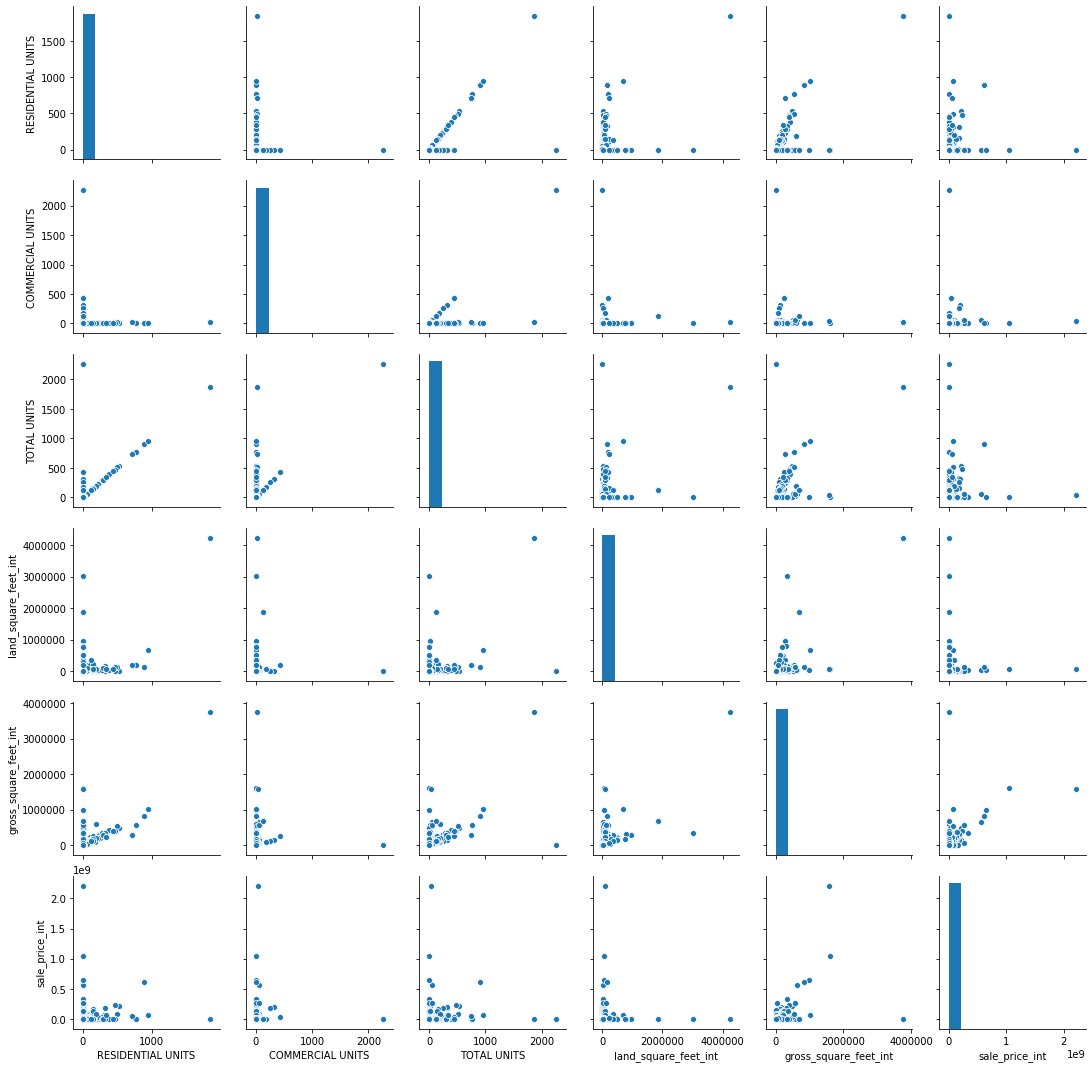

In [258]:
# Correlation plots of the mosts strongly correlated values to sale price
sns.pairplot(home_data[['RESIDENTIAL UNITS','COMMERCIAL UNITS', 'TOTAL UNITS', 'land_square_feet_int',
       'gross_square_feet_int','sale_price_int']])

<function matplotlib.pyplot.show(*args, **kw)>

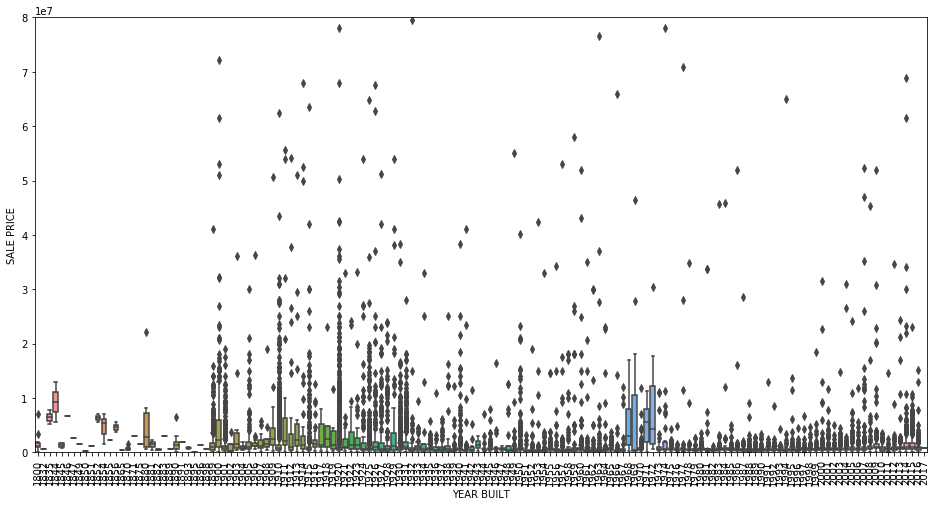

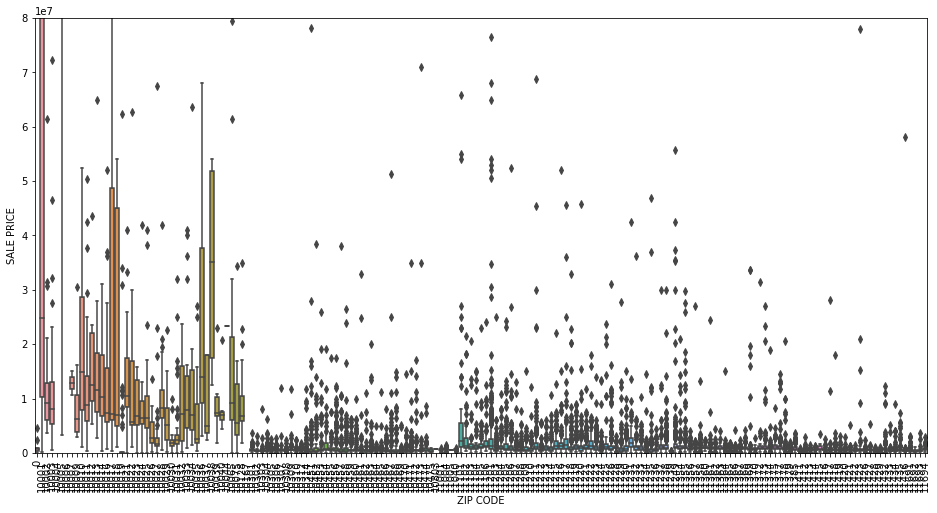

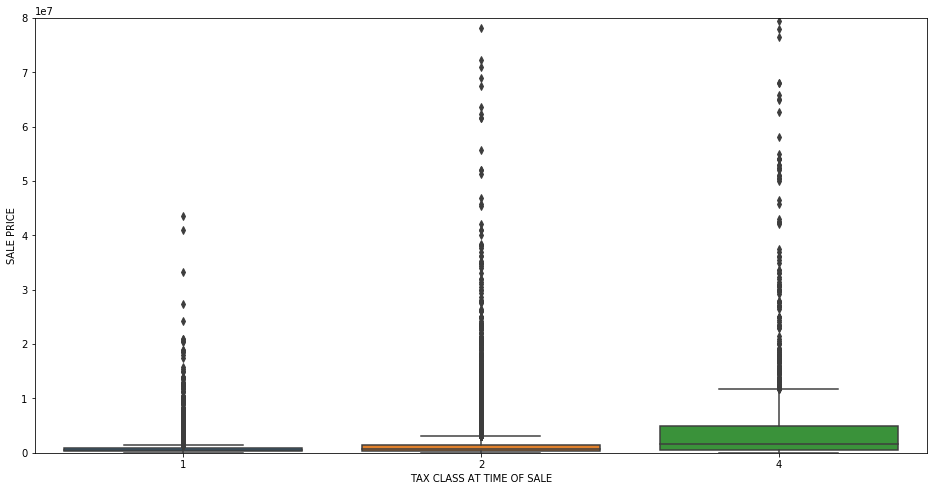

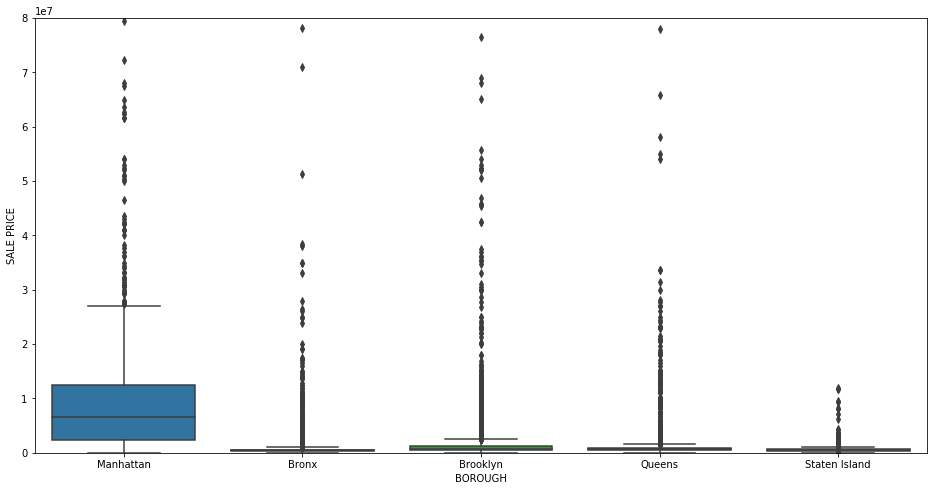

In [282]:
l = ['YEAR BUILT','ZIP CODE','TAX CLASS AT TIME OF SALE']
for var in l:
    data = pd.concat([home_data['sale_price_int'], home_data[var]], axis=1)
    f, ax = plt.subplots(figsize=(16, 8))
    fig = sns.boxplot(x=var, y="sale_price_int", data=data)
    if var == 'ZIP CODE' or var == 'YEAR BUILT':
        plt.xticks(rotation='vertical')
    fig.axis(ymin=0,ymax=80000000)
    plt.ylabel("SALE PRICE")
    
data = pd.concat([home_data['sale_price_int'], home_data['BOROUGH']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='BOROUGH', y="sale_price_int", data=data)
fig.axis(ymin=0,ymax=80000000)
plt.ylabel('SALE PRICE')
plt.xticks(np.arange(5), ('Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island'))
plt.show

All the qualitative variables seem to have some different distributions of price.  However, some observations:
The information in the zip codes can be encapsulated in the boroughs, so no need to create zip code dummy varaibles as we can just encode borough dummy variables. This will save some computation time. The Year Built variable adds a lot of extra parameters for what seems to not add a lot of extra information. we can try including it vs not including it to compare how the model performs. We will definitely include the variables tax class and borough as dummy encodings. 

<function matplotlib.pyplot.show(*args, **kw)>

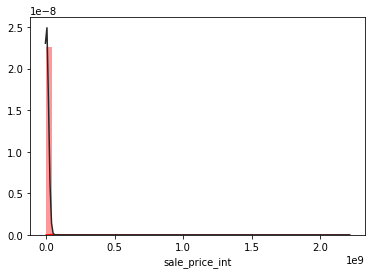

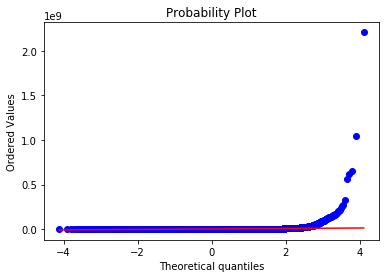

In [283]:
# Whole Dataset sales dist
sns.distplot(home_data['sale_price_int'],color = 'r',fit=norm)
fig = plt.figure()
stats.probplot(home_data['sale_price_int'], plot=plt)
plt.show

In [263]:
#skewness and kurtosis
print("Skewness: %f" % home_data['sale_price_int'].skew())
print("Kurtosis: %f" % home_data['sale_price_int'].kurt())

Skewness: 97.053197
Kurtosis: 12434.027224


The sales data has a very positive skewness, so we will apply a logarithmic transfomation to fix this.  We will also create separate residential and commercial sales to see if there are any noticeable differences in the two.

In [284]:
home_data['sale_price_int'] = np.log(home_data['sale_price_int'])
# Creating Residential Dataset
residential_data = home_data[(home_data['TAX CLASS AT TIME OF SALE'] == 1) | (home_data['TAX CLASS AT TIME OF SALE'] == 2)]
# Creating Commercial Dataset
commercial_data = home_data[(home_data['TAX CLASS AT TIME OF SALE'] == 3) | (home_data['TAX CLASS AT TIME OF SALE'] == 4)]

<function matplotlib.pyplot.show(*args, **kw)>

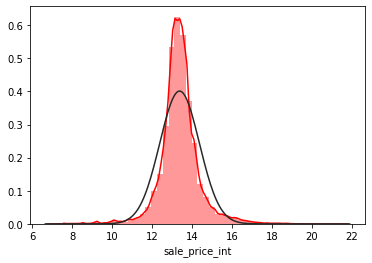

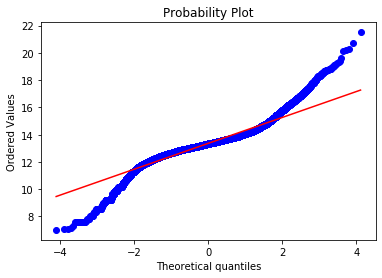

In [265]:
# Whole Dataset sales dist - new
sns.distplot(home_data['sale_price_int'],color = 'r',fit=norm)
fig = plt.figure()
stats.probplot(home_data['sale_price_int'], plot=plt)
plt.show

In [266]:
#skewness and kurtosis
print("Skewness: %f" % home_data['sale_price_int'].skew())
print("Kurtosis: %f" % home_data['sale_price_int'].kurt())

Skewness: 0.196823
Kurtosis: 5.749249


<function matplotlib.pyplot.show(*args, **kw)>

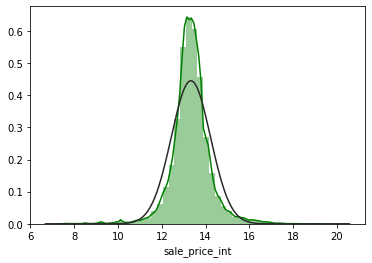

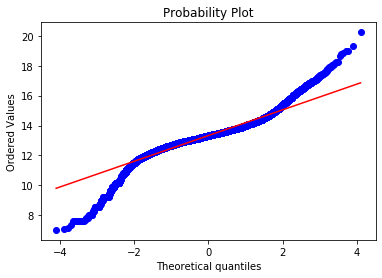

In [267]:
# Residential Dataset sales dist
sns.distplot(residential_data['sale_price_int'],color = 'g',fit=norm)
fig = plt.figure()
stats.probplot(residential_data['sale_price_int'], plot=plt)
plt.show

In [268]:
#skewness and kurtosis
print("Skewness: %f" % residential_data['sale_price_int'].skew())
print("Kurtosis: %f" % residential_data['sale_price_int'].kurt())

Skewness: -0.157492
Kurtosis: 5.709222


<function matplotlib.pyplot.show(*args, **kw)>

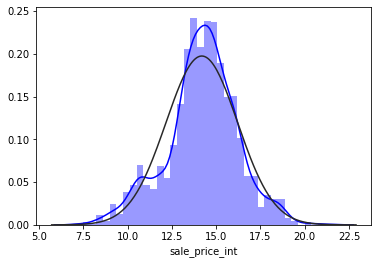

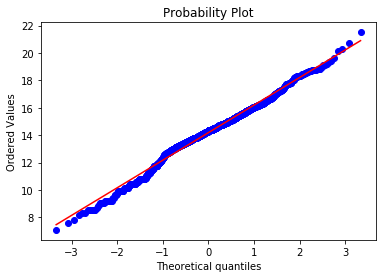

In [269]:
# Commercial Dataset sales dist
sns.distplot(commercial_data['sale_price_int'],color = 'b',fit=norm)
fig = plt.figure()
stats.probplot(commercial_data['sale_price_int'], plot=plt)
plt.show

In [270]:
#skewness and kurtosis
print("Skewness: %f" % commercial_data['sale_price_int'].skew())
print("Kurtosis: %f" % commercial_data['sale_price_int'].kurt())

Skewness: -0.258001
Kurtosis: 0.496105


The entire dataset and residential datasets still do not look entirely normally distributed, but definitely better than before.  The commercial dataset is the the closest to normally distrubuted out of the 3 datasets, but that is most likely because the sample size gets cut down a significant amount.  Since there is not a significant difference between the distributions of the 3 datasets, and we can encapsulate the information of residential vs commercial in the dummy variable of tax class, we will continue the analysys just using the entire dataset.

In [285]:
## ENTIRE SET

# Entire Dataset Response
y = home_data.sale_price_int

# Max / Avg price
max_price = max(y)
avg_price = y.mean()


features = ['RESIDENTIAL UNITS','COMMERCIAL UNITS', 'TOTAL UNITS', 'land_square_feet_int',
       'gross_square_feet_int','BOROUGH','TAX CLASS AT TIME OF SALE','ZIP CODE','YEAR BUILT']

# Entire Dataset Fetures
X = home_data[features]
borough = pd.get_dummies(home_data['BOROUGH'])
X = pd.concat([X,borough],axis=1)
# renaming borough numbers to zones
X = X.rename(columns={1: "Manhattan", 2: "Bronx", 3: "Brooklyn" , 4: "Queens", 5: "Staten Island"})
taxclass = pd.get_dummies(home_data['TAX CLASS AT TIME OF SALE'])
X = pd.concat([X,taxclass],axis=1)
#yearbuilt= pd.get_dummies(home_data['YEAR BUILT'])
#X = pd.concat([X,yearbuilt],axis=1)

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1,test_size=0.2)

print(train_X.shape)
X.head()

(28230, 17)


,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,land_square_feet_int,gross_square_feet_int,BOROUGH,TAX CLASS AT TIME OF SALE,ZIP CODE,YEAR BUILT,Manhattan,Bronx,Brooklyn,Queens,Staten Island,1,2,4
0,5,0,5,1633,6440,1,2,10009,1900,1,0,0,0,0,0,1,0
3,10,0,10,2272,6794,1,2,10009,1913,1,0,0,0,0,0,1,0
4,6,0,6,2369,4615,1,2,10009,1900,1,0,0,0,0,0,1,0
6,8,0,8,1750,4226,1,2,10009,1920,1,0,0,0,0,0,1,0
9,24,0,24,4489,18523,1,2,10009,1920,1,0,0,0,0,0,1,0


Features with year built dummy encodings=165 Features without year built dummy encodings=17

500


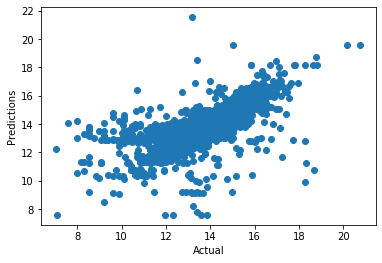

Validation MSE specifying max leaf nodes 0.40413336690636426
0.030231322454212187


In [286]:
#Decision Tree
candidate_max_leaf_nodes = [2,10,100,500,1000]
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
leaf = []
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

for index,n in enumerate(candidate_max_leaf_nodes):
    k = get_mae(n, train_X, val_X, train_y, val_y)
    leaf.append(k) 
# Store the best value of max_leaf_nodes 
best_tree_size = candidate_max_leaf_nodes[leaf.index(min(leaf))]
print(best_tree_size)

# Specify Model
home_model = DecisionTreeRegressor(random_state=0,max_leaf_nodes=best_tree_size)

# Fit Model
home_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = home_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
plt.scatter(val_y,val_predictions)
plt.ylabel('Predictions')
plt.xlabel('Actual')
plt.show()
print("Validation MSE specifying max leaf nodes {}".format(val_mae))
print(val_mae/avg_price)

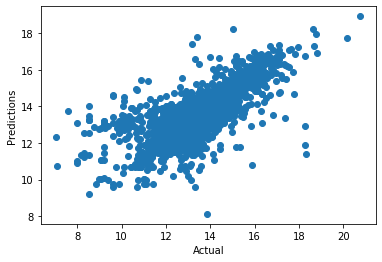

Validation MSE for Random Forest Model: 0.3941004097062955
0.02948080396422355


In [287]:
## RANDOM FOREST
# Define the model
rf_model = RandomForestRegressor(random_state=0,n_estimators=10)

# fit model
rf_model.fit(train_X,train_y)

# Calculate the mean absolute error of Random Forest model on the validation data
val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(val_predictions, val_y)

data = {'predictions':[val_predictions], 'actual':[val_y]} 
  
# Creates pandas DataFrame. 
df = pd.DataFrame(data) 
df.to_csv('df.csv')
plt.scatter(val_y,val_predictions)
plt.ylabel('Predictions')
plt.xlabel('Actual')
plt.show()
print("Validation MSE for Random Forest Model: {}".format(rf_val_mae))
print(rf_val_mae/avg_price)

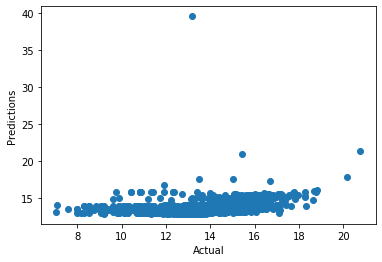

Validation MSE 0.6075247232253248
0.04544607624785949
0.1


RESIDENTIAL UNITS            3.587564e-03
COMMERCIAL UNITS            -6.157763e-04
TOTAL UNITS                  1.414805e-03
land_square_feet_int         7.298250e-07
gross_square_feet_int        3.708926e-06
BOROUGH                     -5.451578e-02
TAX CLASS AT TIME OF SALE    6.390817e-02
ZIP CODE                    -3.698604e-05
YEAR BUILT                  -1.059142e-03
Manhattan                    1.345505e+00
Bronx                       -4.980460e-01
Brooklyn                     1.533318e-01
Queens                       2.824567e-02
Staten Island               -1.789094e-01
1                           -1.498644e-02
2                           -6.420150e-02
4                            3.377545e-01
dtype: float64

In [288]:
# RIDGE
#Fit the model
alpha=[0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6]
ridgereg = lm.RidgeCV(alphas=alpha,normalize=True,cv=5)
ridgereg.fit(train_X,train_y)
val_predictions = ridgereg.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
plt.scatter(val_y,val_predictions)
plt.ylabel('Predictions')
plt.xlabel('Actual')
plt.show()
print("Validation MSE {}".format(val_mae))
print(val_mae/avg_price)
print(ridgereg.alpha_)
coef = pd.Series(ridgereg.coef_, index = train_X.columns)
coef

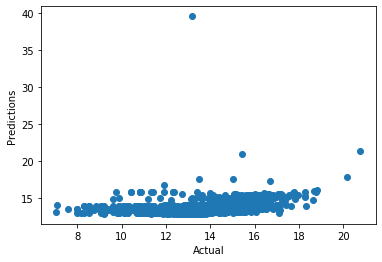

Validation MSE 0.6075247232253248
0.04544607624785949
0.01


RESIDENTIAL UNITS            0.0
COMMERCIAL UNITS             0.0
TOTAL UNITS                  0.0
land_square_feet_int         0.0
gross_square_feet_int        0.0
BOROUGH                     -0.0
TAX CLASS AT TIME OF SALE    0.0
ZIP CODE                     0.0
YEAR BUILT                  -0.0
Manhattan                    0.0
Bronx                       -0.0
Brooklyn                     0.0
Queens                      -0.0
Staten Island               -0.0
1                           -0.0
2                            0.0
4                            0.0
dtype: float64

In [289]:
#LASSO
alpha=[0.01]
lassoreg = lm.LassoCV(alphas=alpha,normalize=True,cv=5)
lassoreg.fit(train_X,train_y)
val_predictions = ridgereg.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
plt.scatter(val_y,val_predictions)
plt.ylabel('Predictions')
plt.xlabel('Actual')
plt.show()
print("Validation MSE {}".format(val_mae))
print(val_mae/avg_price)
print(lassoreg.alpha_)
coef = pd.Series(lassoreg.coef_, index = train_X.columns)
coef

Validation MSE 0.5988760240041273
0.044799107607365884


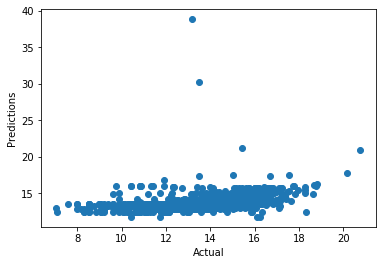

RESIDENTIAL UNITS            1.785074e+00
COMMERCIAL UNITS             1.779943e+00
TOTAL UNITS                 -1.779407e+00
land_square_feet_int         6.816813e-07
gross_square_feet_int        3.257329e-06
BOROUGH                     -2.923787e-01
TAX CLASS AT TIME OF SALE    2.146064e-01
ZIP CODE                    -8.975104e-05
YEAR BUILT                  -5.853136e-04
Manhattan                    7.516309e-01
Bronx                       -9.680425e-01
Brooklyn                     3.541665e-02
Queens                       1.191493e-01
Staten Island                6.184564e-02
1                            5.164266e-02
2                           -1.847672e-01
4                            1.331245e-01
dtype: float64

In [294]:
# Linear Regression
lm = lm.LinearRegression()
model = lm.fit(train_X, train_y)
val_predictions = lm.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MSE {}".format(val_mae))
print(val_mae/avg_price)
plt.scatter(val_y,val_predictions)
plt.ylabel('Predictions')
plt.xlabel('Actual')
coef = pd.Series(model.coef_, index = train_X.columns)
plt.show()
coef

# Conclusions

More data the house would help - other housing datasets
have 100+ predictors (quality of house, # of garages etc.)

Right now Random forest/ decision tree yield the best, but i believe
this is due to outliers in the dataset that are throwing off the linear models,
as evident by the graphs.  Maybe eliminating those outliers would improve the other 
models?

Error validation is just MSE right now - do we want to add more?

- Coefficients on Ridge and Lasso
- for decision tree split into more training (70 15 15)
- add names of boroughs